### Autores:  
Blanco García, Gabriel: gabriel.blanco@cunef.edu  
Ferrín Meilán, Michelle: michelle.ferrin@cunef.edu

## Colegio Universitario de Estudios Financieros
### Máster en Data Science para Finanzas
Madrid, diciembre de 2020

# Ingeniería de variables 

<img src='https://miro.medium.com/max/1454/1*IIzkoFmfkonD50BTQZNU-g.png'>

Se conoce como ingeniería de variables al proceso de generación de nuevas variables en el dataset con el objetivo de mejorar el rendimiento de los modelos. Ese es el motivo de esta sección, aplicar el conocimiento del EDA para la creación de nuevas variables

Importamos las librerías y cargamos los datos resultantes del análisis exploratorio

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# Este notebook contiene nuestras funciones para generar las tablas y gráficos porcentuales
%run ../src/tablas_y_graficos.ipynb

In [2]:
datos = pd.read_csv('../data/intermediate/pre_clean_data.csv', engine='python')

###  FICO 

Las variables fico hacen referencia a un rating externo a lending club, que viene dado en intervalos. La variable low  indica el limite inferior, y la variable high indica el limite superior. Las equivalencias son las siguientes: 
<img src='../images/Captura.jpg'>

Utilizando estas métricas, definimos una función para codificar las columnas, y pasar de dos columnas a una única 

In [3]:
# Definimos la función de transformación de la nota FICO
def rating_fico (x, y):
    if  x >= 800 & y <= 850:
        return 'Exceptional'
    elif x >= 749 & y <= 799:
        return 'Very good'
    elif x >= 670 & y <= 739:
        return 'Good'
    elif x >= 580 & y <= 669:
        return 'Fair'
    else:
        return 'Very poor'

In [4]:
# Aplicamos la función para crear la nueva columna
datos['rating_fico'] = datos.apply(lambda row: 
                                   rating_fico(row['last_fico_range_low'], 
                                               row['last_fico_range_high']), axis = 1)


datos.rating_fico.tail(3) # resultado

462188    Exceptional
462189      Very poor
462190    Exceptional
Name: rating_fico, dtype: object

In [5]:
# Eliminamos las columnas originales 
datos.drop(['last_fico_range_low', 'last_fico_range_high'], axis=1, inplace=True)

Ahora podemos analizar el porcentaje de impago de las categorías de esta variable

In [28]:
impagos_fico = tabla_impagos(datos, 'rating_fico')
impagos_fico

,rating_fico,paga,no paga,total,porcentaje_impago
0,Exceptional,337146,98040,435186,22.53
1,Good,900,4327,5227,82.78
2,Very good,6114,40,6154,0.65
3,Very poor,1360,14264,15624,91.30


Se puede observar como la gran mayoría de los préstamos del dataset fueron concedidos a personas con el mejor rating. Sin embargo, las categorías good y poor tienen un mayor peso, y porcentaje de impago, que la categoría very good. Representamos los resultados 

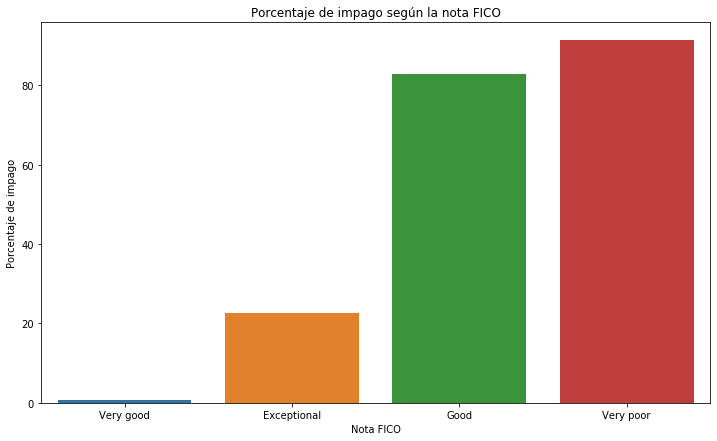

In [30]:
barras_porcentuales(impagos_fico.sort_values(['porcentaje_impago']), 
                    eje_x='rating_fico',
                    titulo='Porcentaje de impago según la nota FICO',
                    etiqueta_x='Nota FICO')

Es evidente que esta nota puede servir para predecir el impago. El efecto de que la categoría excepcional tenga mayores impagos
que very good puede deberse al mayor número de préstamos a esta categoría

### Bancarrotas y registros públicos

Como se comentaba en el EDA, se generan nuevas variables a partir de bancarrotas y registros públicos. Para bancarrotas, se codifica si el prestatario tiene más de 3 bancarrotas en el registro público. Para los registros públicos, se codifica si el prestatario tiene más de 5

In [6]:
# Bancarrotas 
datos.pub_rec_bankruptcies = datos.pub_rec_bankruptcies.map(lambda x: '7 o menos' if x <= 7 else 'Más de 7')

# Registros públicos 
datos.pub_rec = datos.pub_rec.map(lambda x: '11 o menos' if x <= 11 else 'Más de 11')

In [64]:
# Resultado 
datos[['pub_rec_bankruptcies', 'pub_rec']].head()

,pub_rec_bankruptcies,pub_rec
0,7 o menos,11 o menos
1,7 o menos,11 o menos
2,7 o menos,11 o menos
3,7 o menos,11 o menos
4,7 o menos,11 o menos


Podemos volver a calcular los porcentajes y los gráficos

In [65]:
bancarrotas = tabla_impagos(datos, 'pub_rec_bankruptcies')
bancarrotas

,pub_rec_bankruptcies,paga,no paga,total,porcentaje_impago
0,7 o menos,345518,116668,462186,25.24
1,Más de 7,2,3,5,60.00


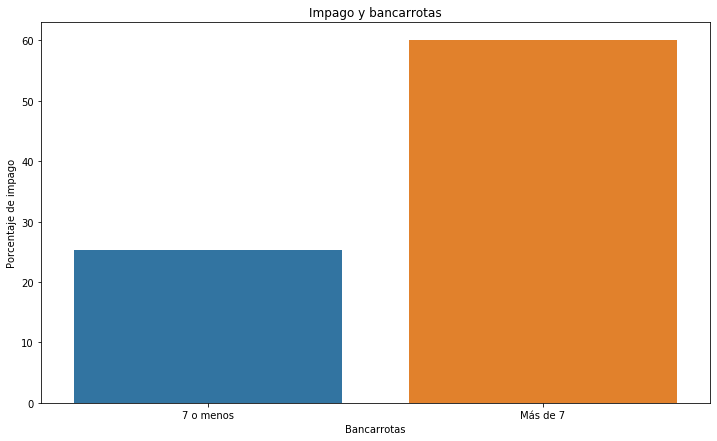

In [66]:
barras_porcentuales(bancarrotas, 
                    eje_x='pub_rec_bankruptcies',
                    titulo='Impago y bancarrotas',
                    etiqueta_x='Bancarrotas')

In [67]:
registros = tabla_impagos(datos, 'pub_rec')
registros

,pub_rec,paga,no paga,total,porcentaje_impago
0,11 o menos,345497,116657,462154,25.24
1,Más de 11,23,14,37,37.84


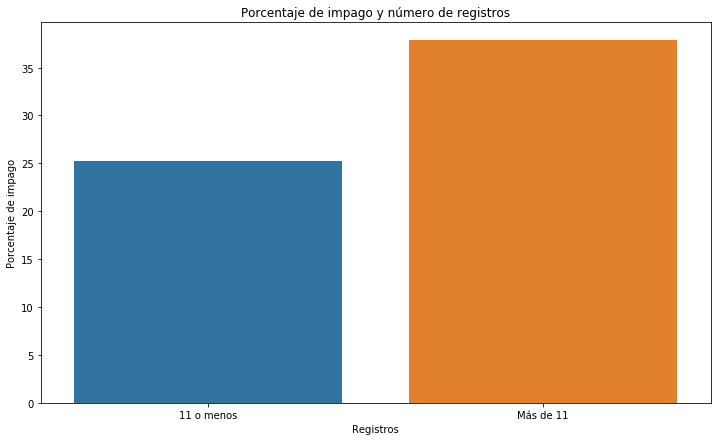

In [68]:
barras_porcentuales(registros,
                    eje_x='pub_rec',
                    titulo='Porcentaje de impago y número de registros',
                    etiqueta_x='Registros')

Vemos como las variables transformadas capturan bien la elevación en la tasa de impago. Será interesante incluirlas en el modelo

# Guardado de los datos 

Finalmente, antes de pasar a la fase de modelado, eliminamos algunas columnas que no utilizaremos para los entrenamientos

In [7]:
datos.drop(['paga', 'no paga', # solo las hemos usado para cálculos 
            'addr_state',  # no la consideramos relevante, y generaría muchísimas columnas al hacer one hot encoding
            'installment', # misma información que loan_amnt, muy correlacionadas
            
            'verification_status_joint', 'verification_status', # no nos interesan estas variables de prestamos conjuntos 
            'sec_app_fico_range_low', 'sec_app_fico_range_high'], 
            axis=1, 
            inplace=True) # para no tener que reasignar 

In [13]:
datos.head() # Estas son las variables con las que vamos a entrenar los modelos

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,loan_status,purpose,dti,mths_since_last_record,pub_rec,application_type,annual_inc_joint,dti_joint,mort_acc,pub_rec_bankruptcies,rating_fico
0,11575,36 months,7.35,A,6 years,OWN,153000.0,Paga,credit_card,16.99,84.0,11 o menos,Individual,NaN,NaN,2,7 o menos,Exceptional
1,7200,36 months,24.85,E,2 years,RENT,50000.0,Paga,debt_consolidation,6.07,NaN,11 o menos,Individual,NaN,NaN,0,7 o menos,Exceptional
2,7500,36 months,7.35,A,7 years,MORTGAGE,110000.0,Paga,debt_consolidation,13.12,NaN,11 o menos,Individual,NaN,NaN,4,7 o menos,Exceptional
3,10000,60 months,16.02,C,7 years,RENT,51979.0,Paga,debt_consolidation,10.11,55.0,11 o menos,Individual,NaN,NaN,0,7 o menos,Exceptional
4,14000,36 months,16.02,C,7 years,MORTGAGE,75000.0,Paga,debt_consolidation,10.86,NaN,11 o menos,Individual,NaN,NaN,1,7 o menos,Exceptional


El motivo de hacer esto aquí es no tener que manipular los datos en los notebooks de los modelos, a parte del preprocesado de los pipelines.  
Eliminamos las columnas paga y no paga porque son columnas del target, y las hemos utilizado de manera auxiliar para los calculos porcentuales. Installment, addr_state y verification status se eliminan por considerarsre irrelevantes. 

El resto de columnas hacen referecia a variables de los préstamos conjuntos, y consideramos que son demasiado específicas

In [8]:
datos.to_csv('../data/clean/clean_data.csv', index=False)